In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

In [3]:
from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from typeguard import typechecked
from typing import Optional

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [6]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Dataset/train',
                                                   target_size = (128,128),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [7]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Dataset/train',
                                                  target_size = (128,128),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [8]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Dataset/test',
                                                  target_size = (128,128),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback

modelFolder = 'model[0]/'

checkpointLoss = ModelCheckpoint(
    f"{modelFolder}bestLoss.hdf5",
    monitor = 'loss',
    verbose = 1,
    save_best_only = True,
    mode = 'auto'
)

checkpointValLoss = ModelCheckpoint(
    f"{modelFolder}bestValLoss.hdf5",
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True,
    mode = 'auto'
)

earlyStopVal = EarlyStopping(monitor ='val_loss', mode='min', verbose =1, patience =10)
earlyStop = EarlyStopping(monitor = 'loss', mode='min', verbose =1, patience =10)

class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.91 and logs.get('loss')<0.001):
      print('\nAkurasi telah mencapai > 95% and loss < 0.001')
      self.model.stop_training = True

callbacks = myCallback()

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(632, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu',strides=1, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation='relu',strides=1, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 632)       182648    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 632)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 632)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        3

In [12]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [13]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [14]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.001 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.001, 5)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [16]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        verbose = 1,
                         callbacks=[callbacks,checkpointValLoss,earlyStopVal],)

Epoch 1/50
129/129 [==============================] - ETA: 0s - loss: 1.0816 - accuracy: 0.7517 - precision: 0.5087 - recall: 0.2006 - auc: 0.7760 - f1_score: 0.2474
Epoch 1: val_loss improved from inf to 1.04080, saving model to model[0]/bestValLoss.hdf5
129/129 [==============================] - 942s 7s/step - loss: 1.0816 - accuracy: 0.7517 - precision: 0.5087 - recall: 0.2006 - auc: 0.7760 - f1_score: 0.2474 - val_loss: 1.0408 - val_accuracy: 0.7502 - val_precision: 0.5005 - val_recall: 0.5005 - val_auc: 0.8123 - val_f1_score: 0.5006
Epoch 2/50
129/129 [==============================] - ETA: 0s - loss: 1.0461 - accuracy: 0.7573 - precision: 0.5345 - recall: 0.2247 - auc: 0.7849 - f1_score: 0.2785
Epoch 2: val_loss did not improve from 1.04080
129/129 [==============================] - 634s 5s/step - loss: 1.0461 - accuracy: 0.7573 - precision: 0.5345 - recall: 0.2247 - auc: 0.7849 - f1_score: 0.2785 - val_loss: 1.0559 - val_accuracy: 0.7502 - val_precision: 0.5005 - val_recall: 0.5

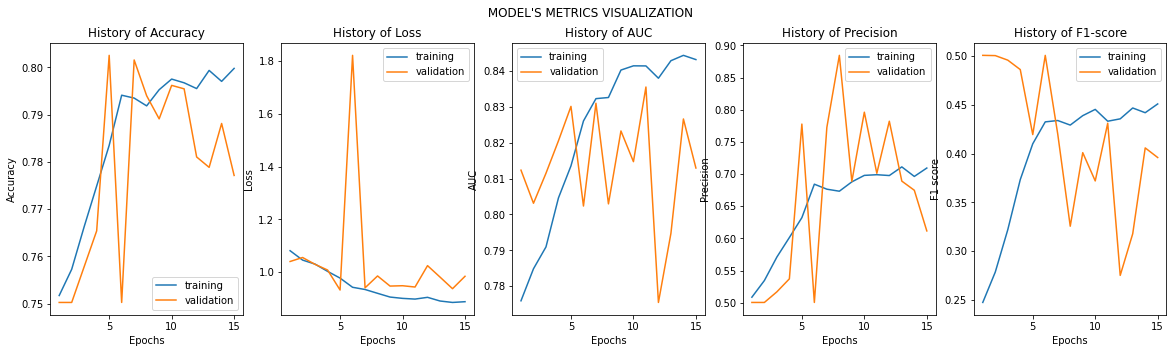

In [17]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])
    
    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
       
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
  
Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [18]:
scores = model.evaluate_generator(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [19]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.8017982840538025
Precision =  0.7378814816474915
Recall =  0.321344792842865
AUC =  0.8449311852455139
F1_score =  0.4438555836677551
